In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("AmesHousing_before.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [3]:
data = data.drop(columns=["Pool QC","Fence","Alley","Misc Feature","Order","PID"])

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['SalePrice'])
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_data = X_train.join(y_train) # Just indexing the column to the right of X_train (since it was removed from X_train)
test_data = X_test.join(y_test)

In [5]:
for col in train_data.select_dtypes(include="object").columns: #only object for now because only ones that need "None" in string
    mode_val = train_data[col].mode()[0] #Find the most common value
    train_data[col] = train_data[col].fillna(mode_val if train_data[col].value_counts()[mode_val] > 100 else "__MISSING__") #If that value appears a lot (100+), use it to fill in blanks. Otherwise, just say 'None' because it's probably missing for a reason.

In [6]:
zeros_fill_cols = [
    'Garage Yr Blt', 'Garage Area', 'Garage Cars',
    'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
    'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath'
]

for col in zeros_fill_cols:
    train_data[col] = train_data[col].fillna(0)

# Separate for Lot frontage (estimate), random missing size
train_data['Lot Frontage'] = train_data['Lot Frontage'].fillna(train_data['Lot Frontage'].median())

array([[<Axes: title={'center': 'MS SubClass'}>,
        <Axes: title={'center': 'Lot Frontage'}>,
        <Axes: title={'center': 'Lot Area'}>,
        <Axes: title={'center': 'Overall Qual'}>,
        <Axes: title={'center': 'Overall Cond'}>,
        <Axes: title={'center': 'Year Built'}>],
       [<Axes: title={'center': 'Year Remod/Add'}>,
        <Axes: title={'center': 'Mas Vnr Area'}>,
        <Axes: title={'center': 'BsmtFin SF 1'}>,
        <Axes: title={'center': 'BsmtFin SF 2'}>,
        <Axes: title={'center': 'Bsmt Unf SF'}>,
        <Axes: title={'center': 'Total Bsmt SF'}>],
       [<Axes: title={'center': '1st Flr SF'}>,
        <Axes: title={'center': '2nd Flr SF'}>,
        <Axes: title={'center': 'Low Qual Fin SF'}>,
        <Axes: title={'center': 'Gr Liv Area'}>,
        <Axes: title={'center': 'Bsmt Full Bath'}>,
        <Axes: title={'center': 'Bsmt Half Bath'}>],
       [<Axes: title={'center': 'Full Bath'}>,
        <Axes: title={'center': 'Half Bath'}>,
      

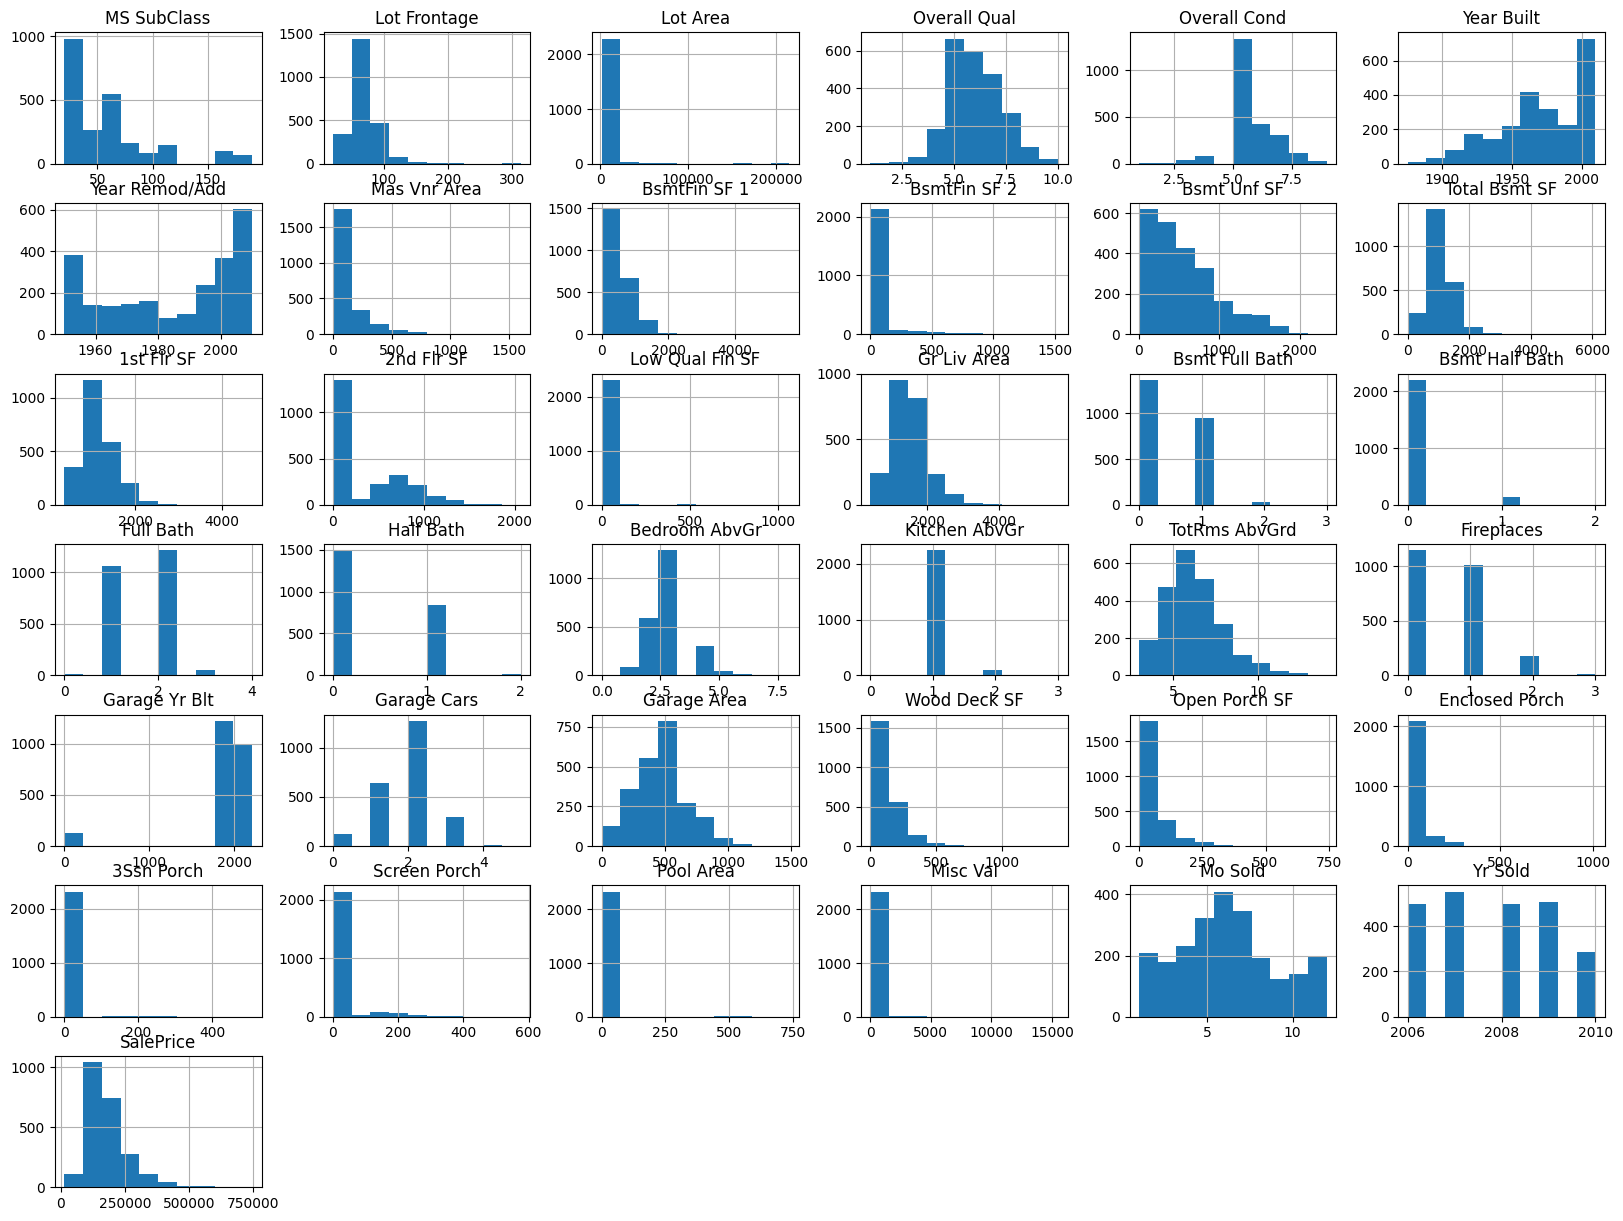

In [7]:
# Exploratory Data Analysis (EDA): Understand the data before modeling
 # Just indexing the column to the right of X_train (since it was removed from X_train)
#train_data = data.copy()
train_data.hist(figsize=(20,15)) # Creates histograms for each numerical column in train_data
# Did train_data.hist() first, but need to arrange visually how it looks so I added plot size with figsize = (width, height)

In [8]:
# Correlation with target variable
train_data.select_dtypes(include="number").corr() # Computes Pearson correlation between every pair of numerical columns. Values range from +1 (as one goes up, so does the other), 0 (no correlation), -1 (as one goes up, the other goes down).

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
MS SubClass,1.000000,-0.380051,-0.232015,0.036266,-0.058469,0.029753,0.043043,0.007936,-0.065266,-0.074741,...,-0.016186,-0.015491,-0.025118,-0.038682,-0.060431,-0.008619,-0.024020,-0.000600,-0.015388,-0.089152
Lot Frontage,-0.380051,1.000000,0.385402,0.197226,-0.057766,0.110109,0.088458,0.197540,0.199944,0.051620,...,0.096511,0.137995,0.018701,0.036493,0.076058,0.179892,0.005442,0.016375,-0.007092,0.336461
Lot Area,-0.232015,0.385402,1.000000,0.100960,-0.034842,0.020824,0.019327,0.124799,0.185914,0.099076,...,0.116683,0.113898,0.030781,0.020331,0.065983,0.113224,0.030570,0.003934,-0.025720,0.278955
Overall Qual,0.036266,0.197226,0.100960,1.000000,-0.088266,0.609083,0.564872,0.420962,0.280392,-0.029277,...,0.260583,0.291611,-0.150386,0.026801,0.053997,0.032006,-0.028734,0.035467,-0.014308,0.798607
Overall Cond,-0.058469,-0.057766,-0.034842,-0.088266,1.000000,-0.344527,0.059302,-0.122027,-0.040336,0.037949,...,0.033764,-0.053811,0.046166,0.044171,0.036574,-0.005911,0.045065,-0.006592,0.015476,-0.094298
Year Built,0.029753,0.110109,0.020824,0.609083,-0.344527,1.000000,0.615575,0.306594,0.275567,-0.026434,...,0.231289,0.186774,-0.368242,0.022020,-0.038132,0.002150,-0.027880,0.024874,-0.008916,0.561446
Year Remod/Add,0.043043,0.088458,0.019327,0.564872,0.059302,0.615575,1.000000,0.189505,0.148793,-0.063553,...,0.223296,0.238984,-0.225247,0.044796,-0.042405,-0.008864,-0.019364,0.024926,0.032739,0.528697
Mas Vnr Area,0.007936,0.197540,0.124799,0.420962,-0.122027,0.306594,0.189505,1.000000,0.276165,-0.002261,...,0.165267,0.123331,-0.114029,0.021357,0.075814,0.003365,-0.026663,0.005317,-0.026789,0.497684
BsmtFin SF 1,-0.065266,0.199944,0.185914,0.280392,-0.040336,0.275567,0.148793,0.276165,1.000000,-0.054666,...,0.209264,0.111122,-0.097231,0.052269,0.106653,0.091278,0.015153,-0.022022,0.026641,0.432220
BsmtFin SF 2,-0.074741,0.051620,0.099076,-0.029277,0.037949,-0.026434,-0.063553,-0.002261,-0.054666,1.000000,...,0.092096,-0.006500,0.045950,-0.020824,0.060340,0.029354,-0.003177,-0.006636,0.006159,0.020352


<Axes: >

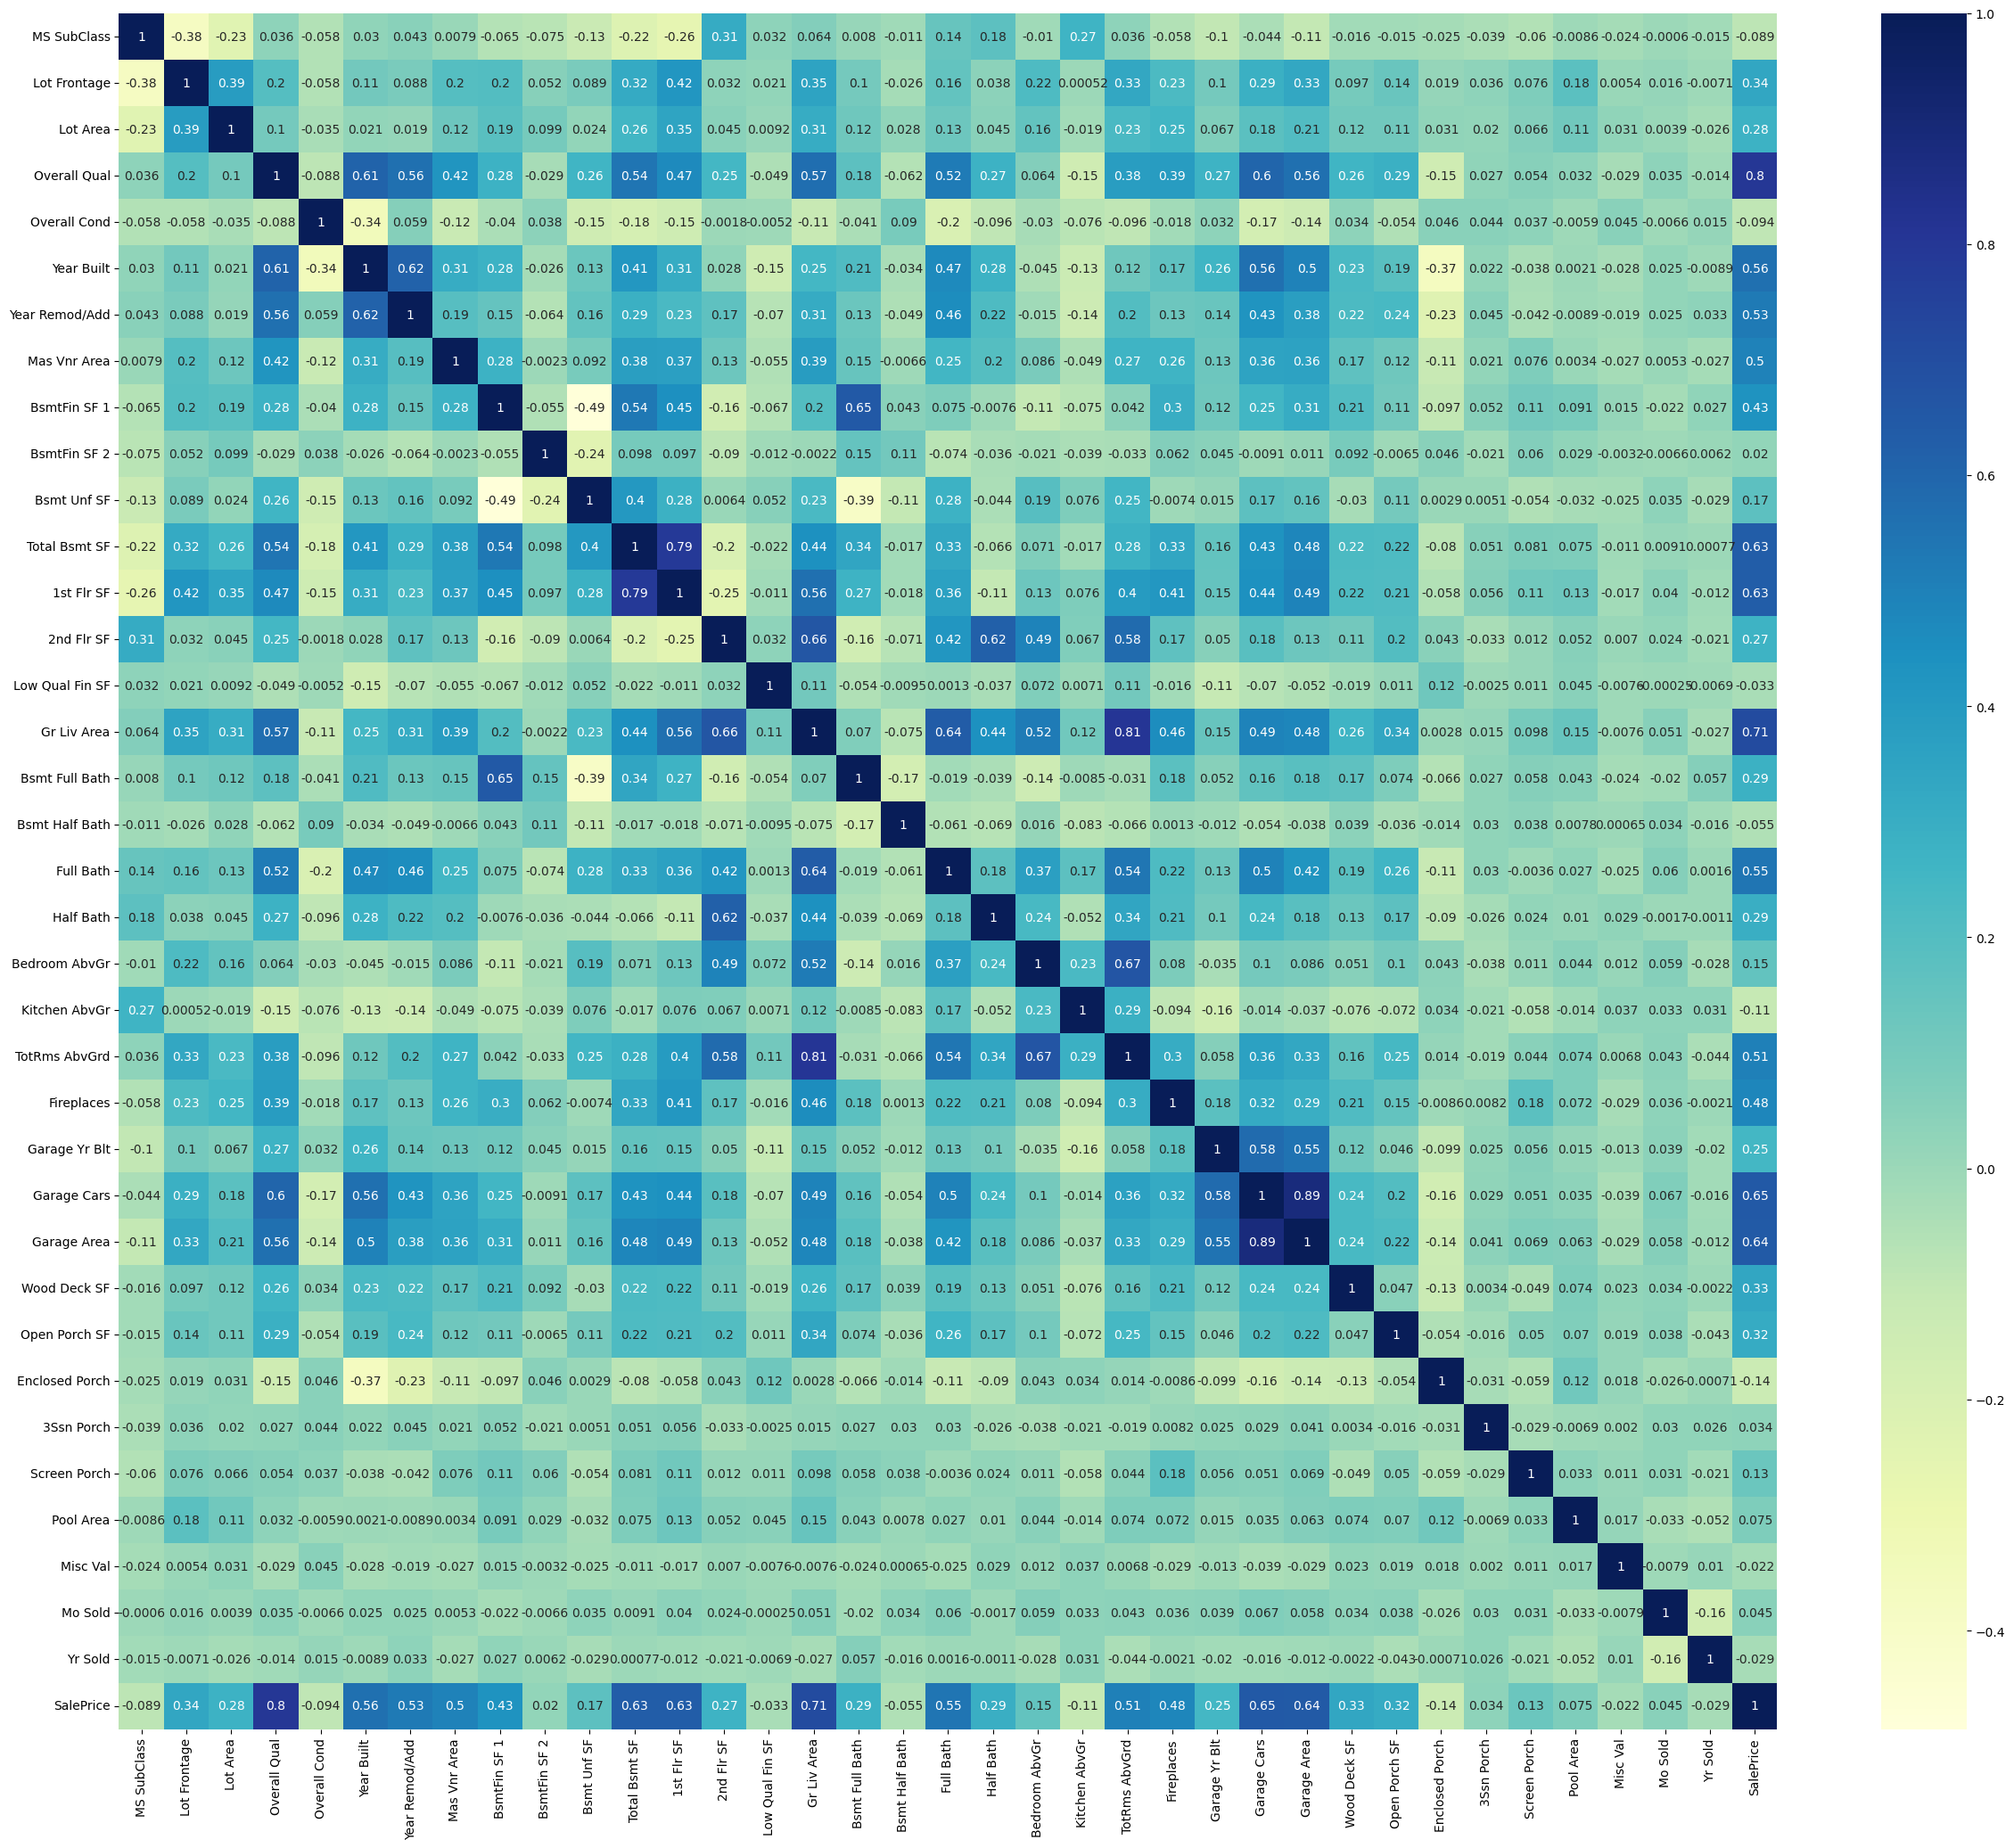

In [9]:
plt.figure(figsize=(30,25)) # rule of thumb: figsize = (num_columns * 1, num_columns * 0.5)
sns.heatmap(train_data.select_dtypes(include="number").corr(),annot=True, cmap="YlGnBu") # Heatmap, annot=True = aka we're going to see the correlation number

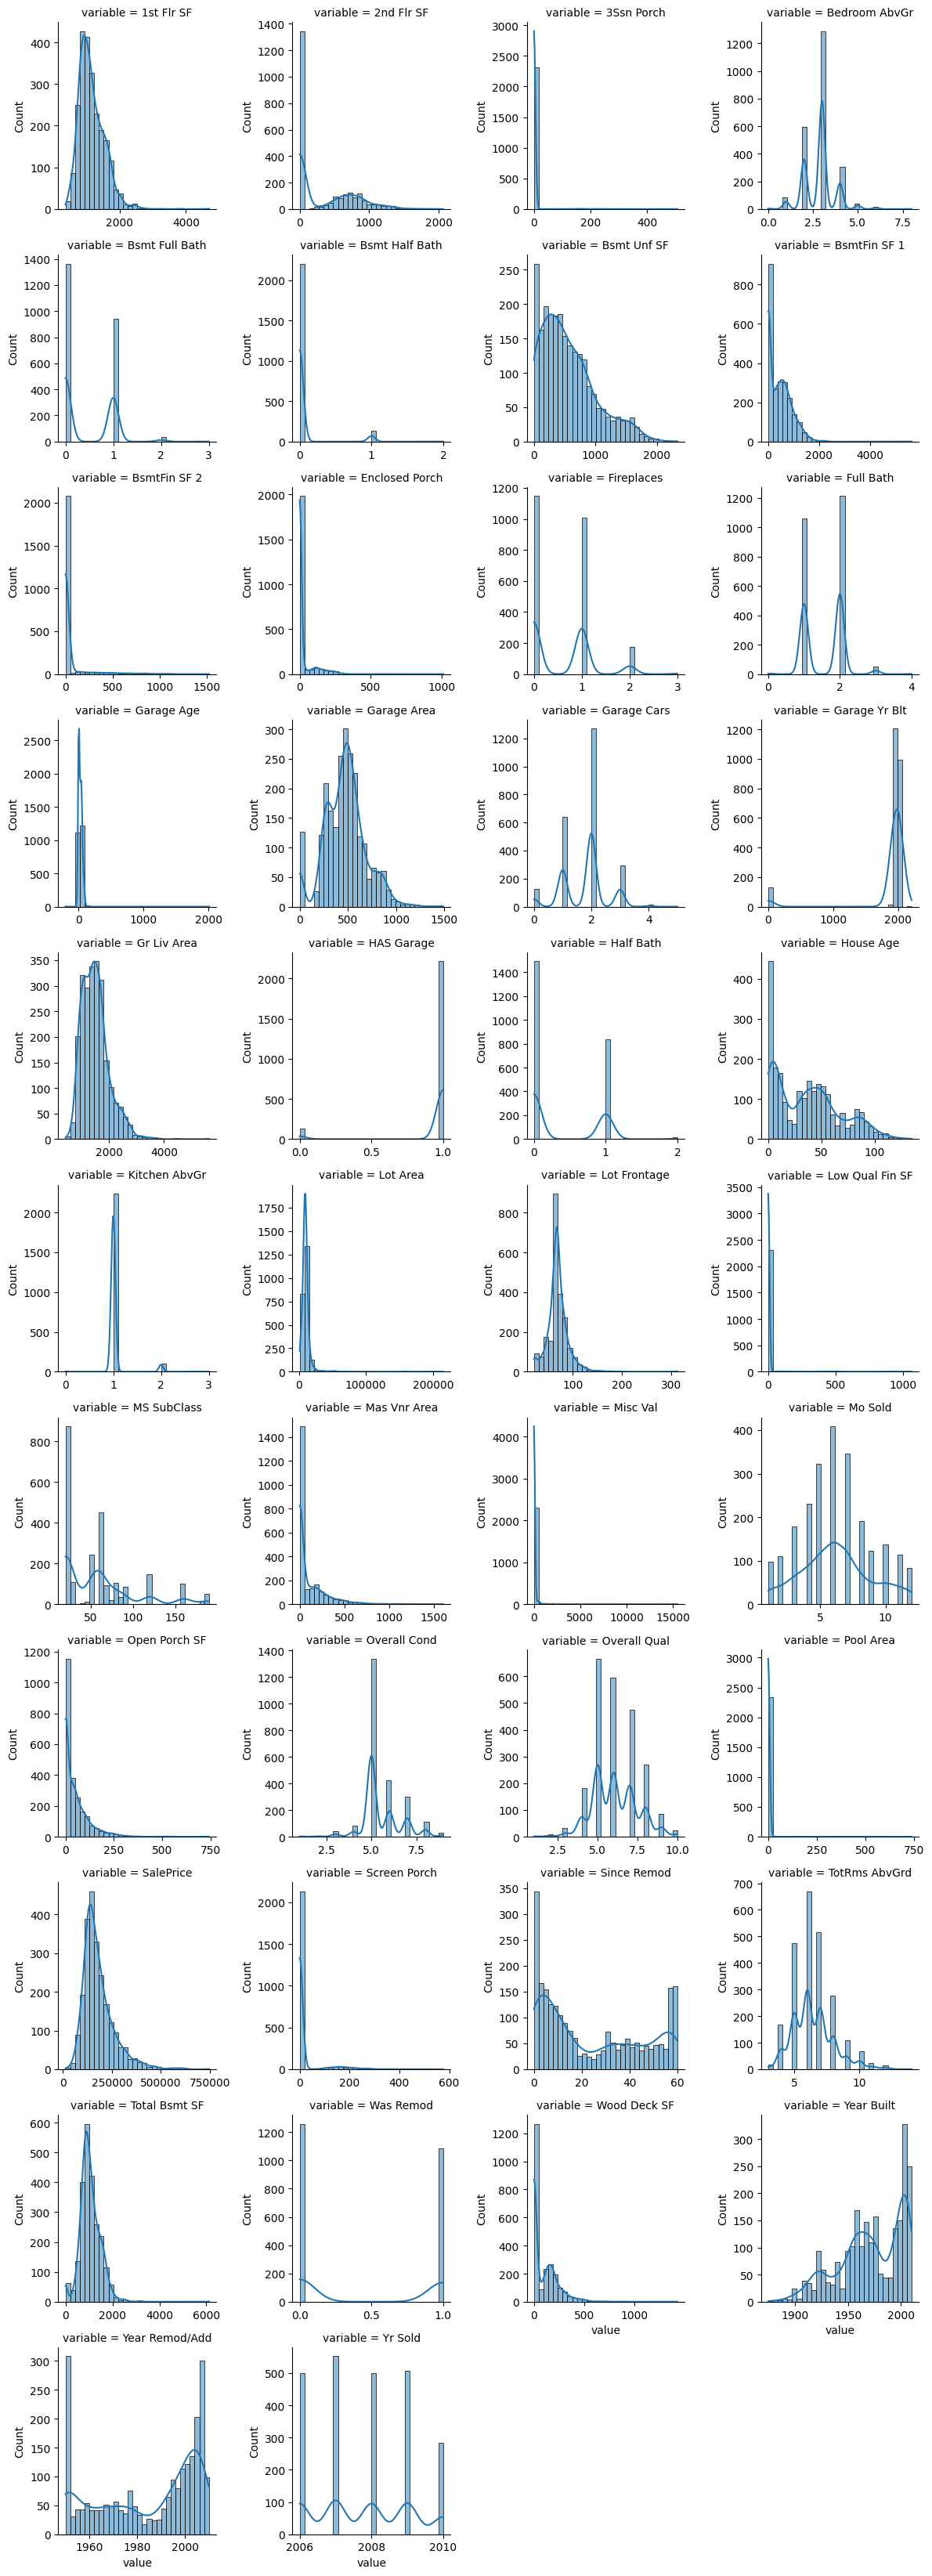

In [10]:
# === Age Features ===
train_data['House Age'] = train_data['Yr Sold'] - train_data['Year Built']
train_data['Since Remod'] = train_data['Yr Sold'] - train_data['Year Remod/Add'] # By doing this line, we see there's an error in hour dataset (house sold before it's built) so we drop that row
train_data = train_data[(train_data['House Age'] >= 0) & (train_data['Since Remod'] >= 0)].copy() # Dropping the rows where the house's age is under 0
train_data['Was Remod'] = (train_data['Year Built'] != train_data['Year Remod/Add']).astype(int)

# === Garage Features ===
train_data['HAS Garage'] = (train_data['Garage Area'] > 0).astype(int)
# First set Garage Yr Blt = NaN for houses with no garage
train_data.loc[train_data['HAS Garage'] == 0, 'Garage Yr Blt'] = np.nan
train_data['Garage Age'] = (train_data['Yr Sold'] - train_data['Garage Yr Blt']).fillna(-1)
train_data['Garage Yr Blt'] = train_data['Garage Yr Blt'].fillna(-1)

# BEFORE graphs
# 1. Grab all numerical columns from your train_data
num_features = train_data.select_dtypes(include='number').columns

# 2. Melt the dataframe to long format for FacetGrid
melted = pd.melt(train_data, value_vars=sorted(num_features))

# 3. Plot with FacetGrid and histplot
g = sns.FacetGrid(melted, col='variable', col_wrap=4, sharex=False, sharey=False, height=3)
g.map(sns.histplot, 'value', kde=True, bins=30)

plt.tight_layout()
plt.show()

In [11]:
# Calculate skewness of numeric features
skew_values = train_data.select_dtypes(include='number').skew()

# Sort by absolute skew (most skewed features first)
skew_sorted = skew_values.sort_values(ascending=False)

# Show top skewed features
print(skew_sorted)

Garage Age         29.210251
Misc Val           20.799427
Pool Area          15.532809
Lot Area           13.053694
Low Qual Fin SF    12.663928
3Ssn Porch         11.658094
Kitchen AbvGr       4.331556
Enclosed Porch      4.221365
BsmtFin SF 2        4.200254
Screen Porch        3.972897
Bsmt Half Bath      3.947640
Mas Vnr Area        2.652287
Open Porch SF       2.566442
Wood Deck SF        1.929219
Lot Frontage        1.896661
SalePrice           1.745642
BsmtFin SF 1        1.418941
MS SubClass         1.387569
1st Flr SF          1.277668
Gr Liv Area         1.195659
Total Bsmt SF       1.092813
Bsmt Unf SF         0.922177
2nd Flr SF          0.875044
TotRms AbvGrd       0.750318
Fireplaces          0.733843
Half Bath           0.718057
Bsmt Full Bath      0.640592
House Age           0.573191
Overall Cond        0.528732
Since Remod         0.445620
Bedroom AbvGr       0.344982
Full Bath           0.224790
Overall Qual        0.217773
Mo Sold             0.205320
Garage Area   

In [12]:
# === Log-Transform Skewed Numeric Features ===
log_cols = ['SalePrice', 'Lot Frontage', 'Lot Area', '1st Flr SF', 'Gr Liv Area', 'Total Bsmt SF']
for col in log_cols:
    train_data[col] = np.log(train_data[col] + 1)

# === Binary Flags for Presence of Features ===
binary_flags = {
    'Bsmt Unf SF': 'HAS Bsmt Unf',
    'Enclosed Porch': 'HAS Enclosed Porch',
    '3Ssn Porch': 'HAS 3Ssn Porch',
    'Screen Porch': 'HAS Screen Porch',
    'Open Porch SF': 'HAS Open Porch SF',
    'Wood Deck SF': 'HAS Wood Deck SF',
    'Pool Area': 'HAS Pool Area',
    'Misc Val': 'HAS Misc Val',
    'Mas Vnr Area': 'HAS Mas Vnr',
    'BsmtFin SF 1': 'HAS BsmtFin 1',
    'BsmtFin SF 2': 'HAS BsmtFin 2',
    '2nd Flr SF': 'HAS 2nd Flr',
    'Low Qual Fin SF': 'HAS Low Qual Fin',
    'Bsmt Full Bath': 'HAS Bsmt Full Bath',
    'Bsmt Half Bath': 'HAS Bsmt Half Bath'
}

for src_col, new_col in binary_flags.items():
    train_data[new_col] = (train_data[src_col] > 0).astype(int)

# === Fix MS SubClass as Categorical ===
train_data['MS SubClass'] = train_data['MS SubClass'].astype(str)

# === One-Hot Encoding Categorical columns ===
categorical_cols = train_data.select_dtypes(include = 'object').columns

train_data = pd.get_dummies(train_data, columns = categorical_cols, drop_first = True)

In [13]:
for col in categorical_cols:
    print(col, data[col].nunique())

MS SubClass 16
MS Zoning 7
Street 2
Lot Shape 4
Land Contour 4
Utilities 3
Lot Config 5
Land Slope 3
Neighborhood 28
Condition 1 9
Condition 2 8
Bldg Type 5
House Style 8
Roof Style 6
Roof Matl 8
Exterior 1st 16
Exterior 2nd 17
Mas Vnr Type 4
Exter Qual 4
Exter Cond 5
Foundation 6
Bsmt Qual 5
Bsmt Cond 5
Bsmt Exposure 4
BsmtFin Type 1 6
BsmtFin Type 2 6
Heating 6
Heating QC 5
Central Air 2
Electrical 5
Kitchen Qual 5
Functional 8
Fireplace Qu 5
Garage Type 6
Garage Finish 3
Garage Qual 5
Garage Cond 5
Paved Drive 3
Sale Type 10
Sale Condition 6


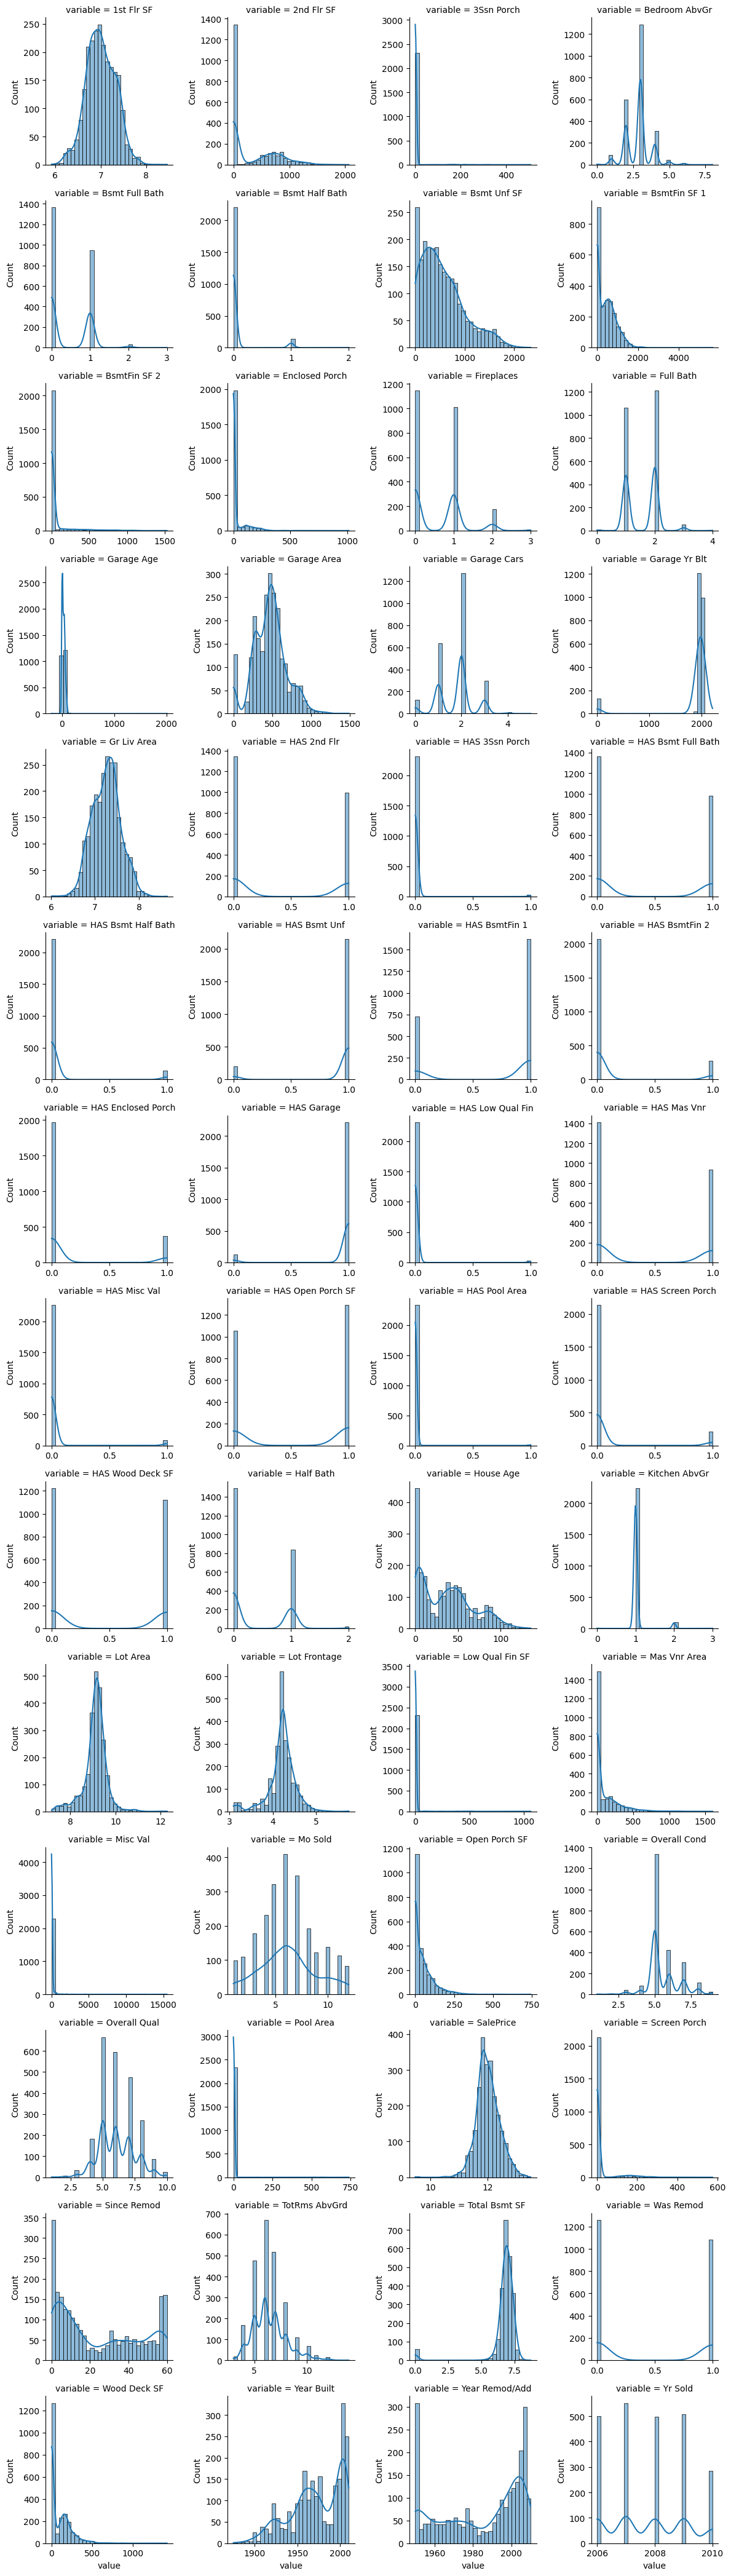

In [14]:
# 1. Grab all numerical columns from your train_data
num_features = train_data.select_dtypes(include='number').columns

# 2. Melt the dataframe to long format for FacetGrid
melted = pd.melt(train_data, value_vars=sorted(num_features))

# 3. Plot with FacetGrid and histplot
g = sns.FacetGrid(melted, col='variable', col_wrap=4, sharex=False, sharey=False, height=3)
g.map(sns.histplot, 'value', kde=True, bins=30)

plt.tight_layout()
plt.show()

In [15]:
pd.set_option('display.max_columns', None)
train_data.head()
train_data.to_csv("preprocessed_data.csv", index=False)

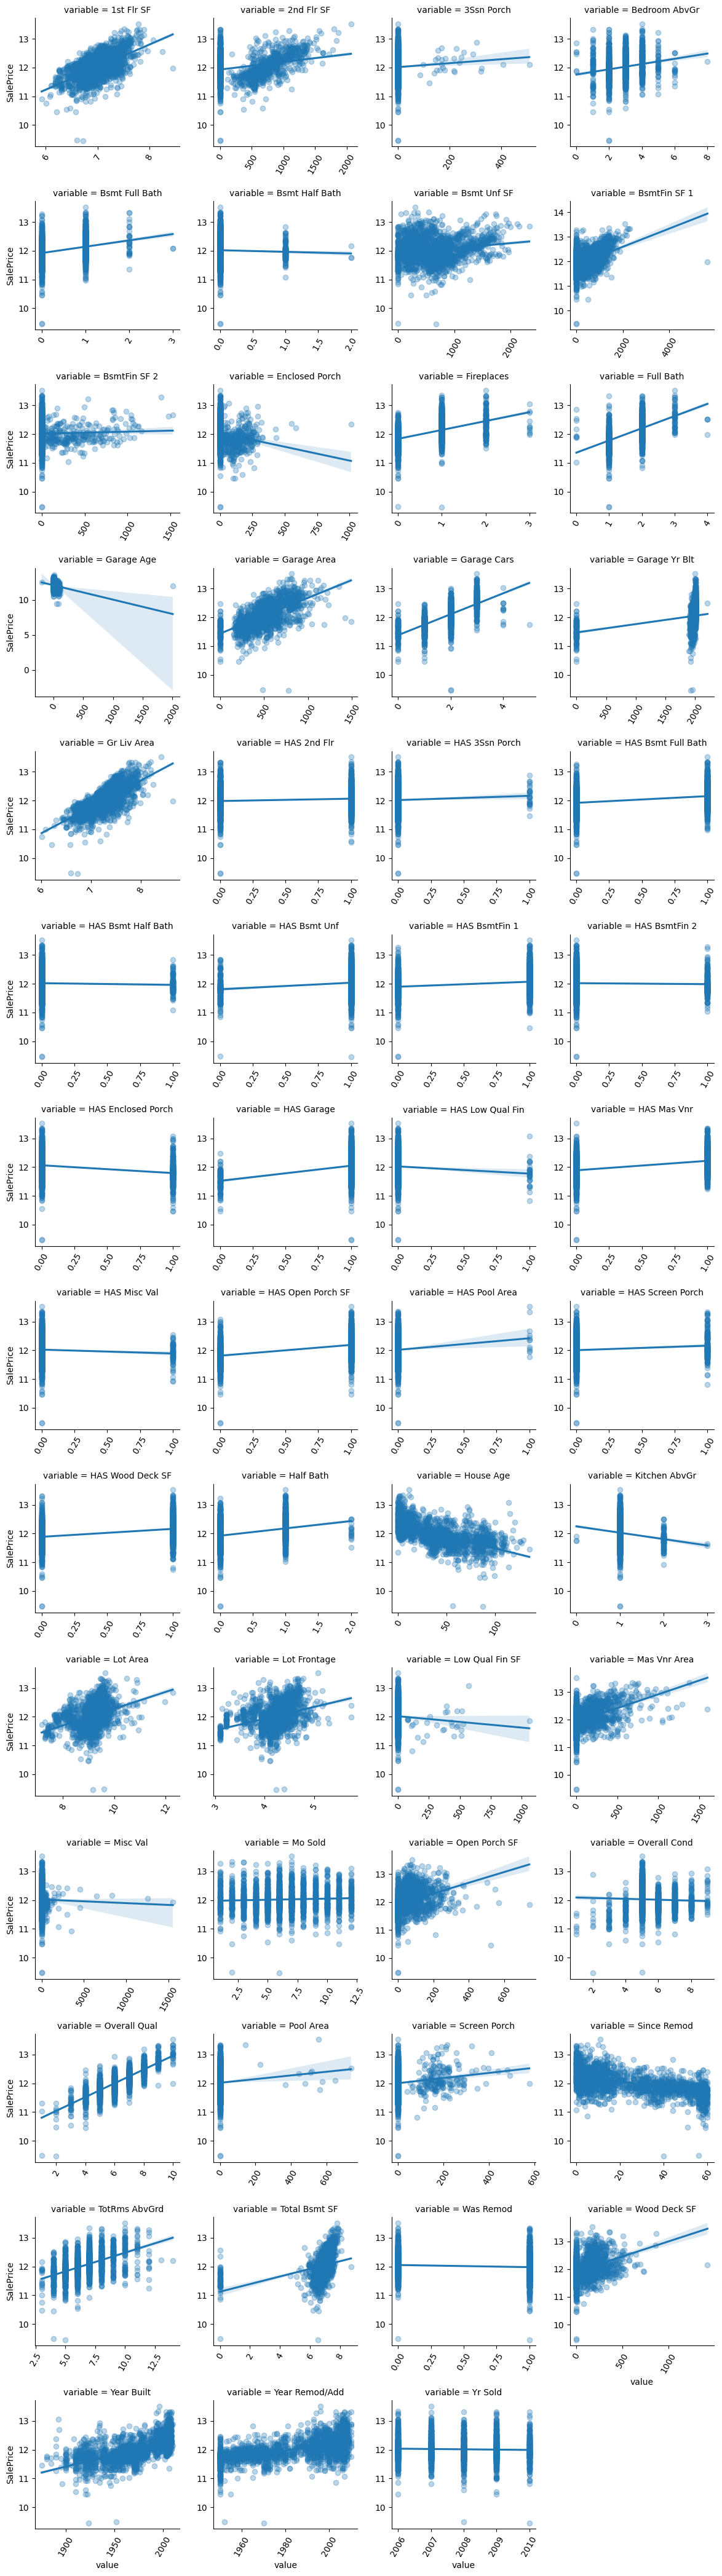

In [16]:
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

In [17]:
test_data = X_test.join(y_test)

# Do the same thing with test dataset (20%)
for col in test_data.select_dtypes(include="object").columns: 
    mode_val = test_data[col].mode()[0] 
    test_data[col] = test_data[col].fillna(mode_val if test_data[col].value_counts()[mode_val] > 100 else "__MISSING__")
zeros_fill_cols = [
    'Garage Yr Blt', 'Garage Area', 'Garage Cars',
    'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
    'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath'
]

for col in zeros_fill_cols:
    test_data[col] = test_data[col].fillna(0)
# Separate for Lot frontage (estimate), random missing size
test_data['Lot Frontage'] = test_data['Lot Frontage'].fillna(test_data['Lot Frontage'].median())
# === Age Features ===
test_data['House Age'] = test_data['Yr Sold'] - test_data['Year Built']
test_data['Since Remod'] = test_data['Yr Sold'] - test_data['Year Remod/Add'] # By doing this line, we see there's an error in hour dataset (house sold before it's built) so we drop that row
test_data = test_data[(test_data['House Age'] >= 0) & (test_data['Since Remod'] >= 0)].copy() # Dropping the rows where the house's age is under 0
test_data['Was Remod'] = (test_data['Year Built'] != test_data['Year Remod/Add']).astype(int)
# === Garage Features ===
test_data['HAS Garage'] = (test_data['Garage Area'] > 0).astype(int)
# First set Garage Yr Blt = NaN for houses with no garage
test_data.loc[test_data['HAS Garage'] == 0, 'Garage Yr Blt'] = np.nan
test_data['Garage Age'] = (test_data['Yr Sold'] - test_data['Garage Yr Blt']).fillna(-1)
test_data['Garage Yr Blt'] = test_data['Garage Yr Blt'].fillna(-1)
# === Log-Transform Skewed Numeric Features ===
log_cols = ['SalePrice', 'Lot Frontage', 'Lot Area', '1st Flr SF', 'Gr Liv Area', 'Total Bsmt SF']
for col in log_cols:
    test_data[col] = np.log(test_data[col] + 1)
# === Binary Flags for Presence of Features ===
binary_flags = {
    'Bsmt Unf SF': 'HAS Bsmt Unf',
    'Enclosed Porch': 'HAS Enclosed Porch',
    '3Ssn Porch': 'HAS 3Ssn Porch',
    'Screen Porch': 'HAS Screen Porch',
    'Open Porch SF': 'HAS Open Porch SF',
    'Wood Deck SF': 'HAS Wood Deck SF',
    'Pool Area': 'HAS Pool Area',
    'Misc Val': 'HAS Misc Val',
    'Mas Vnr Area': 'HAS Mas Vnr',
    'BsmtFin SF 1': 'HAS BsmtFin 1',
    'BsmtFin SF 2': 'HAS BsmtFin 2',
    '2nd Flr SF': 'HAS 2nd Flr',
    'Low Qual Fin SF': 'HAS Low Qual Fin',
    'Bsmt Full Bath': 'HAS Bsmt Full Bath',
    'Bsmt Half Bath': 'HAS Bsmt Half Bath'
}
for src_col, new_col in binary_flags.items():
    test_data[new_col] = (test_data[src_col] > 0).astype(int)
# === Fix MS SubClass as Categorical ===
test_data['MS SubClass'] = test_data['MS SubClass'].astype(str)
# === One-Hot Encoding Categorical columns ===
categorical_cols = test_data.select_dtypes(include = 'object').columns
test_data = pd.get_dummies(test_data, columns = categorical_cols, drop_first = True)


In [18]:
# Since pd.get_dummies() only creates columns for categories that actually appear, if a category is missing in the test data, we will have less columns
if test_data.shape[1] != train_data.shape[1]:
    test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

In [19]:
X_train = train_data.drop(columns='SalePrice')
y_train = train_data['SalePrice']

X_test = test_data.drop(columns='SalePrice')
y_test = test_data['SalePrice']

In [20]:
#print("Sample y_train values:", y_train.head())
#print("Max y_train:", y_train.max())
#print("Min y_train:", y_train.min())

#print("X_train shape:", X_train.shape)
#print("X_test shape:", X_test.shape)
#print("Do columns match:", all(X_train.columns == X_test.columns))

In [21]:
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

Series([], dtype: int64)
Series([], dtype: int64)


In [22]:
# # Selecting our model:
# from sklearn.ensemble import RandomForestRegressor # use RandomForestRegressor model from scikit-learn
# from sklearn.metrics import mean_squared_error # we got tools to check how good the model is, after making predictions

# # 1. Train the model
# lr_model = RandomForestRegressor() # creates an empty RandomForestRegressor model, not trained
# lr_model.fit(X_train, y_train) # we train the model using training data (X_train and y_train) (model learns the pattern and tries to find the best line that fits the data
# lr_model.score(X_test, y_test)

In [23]:
# # 2. Predict
# y_pred = lr_model.predict(X_test) # use the trained model to make predicitons on the new data (X_test) to get an estimate of what the y values should be

# # 3. Evaluate
# rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # we compare the model's predicitons (y_pred) with the actual values (y_test) to calculate the Root Mean Squared Error (RMSE) the smaller it is the better 
# r2 = r2_score(y_test, y_pred)

# print("Sample y_test values:", y_test.head()) #added
# print("RMSE:", rmse)
# print("R²:", r2)

# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.xlabel("Actual SalePrice")
# plt.ylabel("Predicted SalePrice")
# plt.title("Actual vs. Predicted SalePrice")
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # perfect prediction line
# plt.show()

Sample y_test values: 2641    11.848690
2544    12.132970
1600    11.302217
329     11.238502
2159    12.128117
Name: SalePrice, dtype: float64
RMSE: 0.11463053978906299
R²: 0.9197075553473159


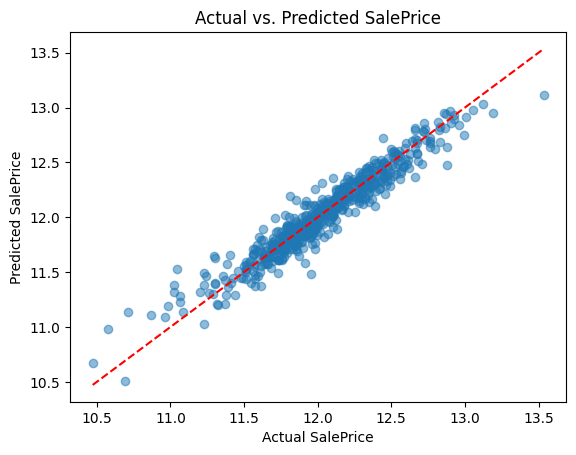

In [24]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Train the model
lr_model = XGBRegressor(random_state=42) # creates an empty XGBRegressor model, not trained
lr_model.fit(X_train, y_train) # we train the model using training data (X_train and y_train) (model learns the pattern and tries to find the best line that fits the data
lr_model.score(X_test, y_test)

# 2. Predict
y_pred = lr_model.predict(X_test) # use the trained model to make predicitons on the new data (X_test) to get an estimate of what the y values should be

# 3. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # we compare the model's predicitons (y_pred) with the actual values (y_test) to calculate the Root Mean Squared Error (RMSE) the smaller it is the better 
r2 = r2_score(y_test, y_pred)

print("Sample y_test values:", y_test.head()) #added
print("RMSE:", rmse)
print("R²:", r2)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs. Predicted SalePrice")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # perfect prediction line
plt.show()

In [25]:
import joblib

# Save model
joblib.dump(lr_model, "XGBRegressor_model.pkl")

# Save the list of columns your model expects
joblib.dump(X_train.columns.tolist(), "model_features.pkl")

['model_features.pkl']

Central Air_Y        0.231807
Overall Qual         0.187942
Garage Cars          0.111583
Full Bath            0.048073
Kitchen Qual_TA      0.028034
Kitchen AbvGr        0.025103
Gr Liv Area          0.019850
MS Zoning_RM         0.017067
Paved Drive_Y        0.016387
MS Zoning_RL         0.015142
Fireplaces           0.013501
House Age            0.011841
Exter Cond_Fa        0.010761
Garage Finish_Unf    0.010605
MS SubClass_30       0.010099
Total Bsmt SF        0.009732
MS SubClass_20       0.009112
1st Flr SF           0.008889
Since Remod          0.008799
Bsmt Full Bath       0.008490
dtype: float32


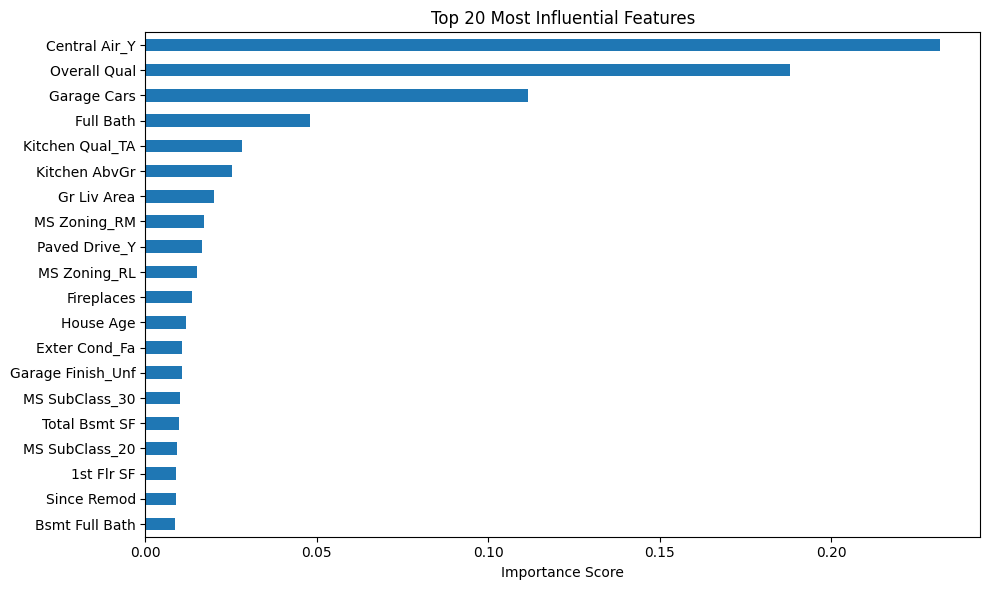

In [27]:
feature_importance = pd.Series(lr_model.feature_importances_, index=lr_model.feature_names_in_)
top_20 = feature_importance.sort_values(ascending=False).head(20)
print(top_20)


top_20.plot(kind="barh", figsize=(10,6))
plt.gca().invert_yaxis()  # Show most important at top
plt.title("Top 20 Most Influential Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()